In [2]:
from params import LocationConfig, TrainingConfig, CreateDataConfig, NetworkConfig
from datamodule import Datamodule
from models.cnn8 import CNN8, CNN8simple
from models.mlp import MLP, MLPsimple

from pathlib import Path
from tqdm import tqdm
from glob import glob
import numpy as np
import cv2

import torchvision.transforms as transforms
from torch.nn import functional as F
from torchsummary import summary
import torch

In [23]:
dataset_name = 'BFD'
dataset_type = 'enc'

In [24]:
channel_size = 1 if dataset_type=='gray' else 3
if dataset_name=='BFD':
    input_shape = (311, 243, channel_size)
else:
    input_shape = (152, 114, channel_size)

In [25]:
if dataset_type=='enc':
    model = MLP(
        lr=NetworkConfig.lr,
        batch_norm=NetworkConfig.batch_norm,
        negative_slope=NetworkConfig.negative_slope,
        dropout = NetworkConfig.dropout
        )
    input_shape = (128,)
else:
    model = CNN8(
            lr=NetworkConfig.lr,
            batch_norm=NetworkConfig.batch_norm,
            negative_slope=NetworkConfig.negative_slope,
            dropout = NetworkConfig.dropout,
            data_type = dataset_type,
            dataset = dataset_name
            )

In [26]:
summary(model.cuda(), input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           8,256
       BatchNorm1d-2                   [-1, 64]             128
              ReLU-3                   [-1, 64]               0
           Dropout-4                   [-1, 64]               0
            Linear-5                   [-1, 32]           2,080
       BatchNorm1d-6                   [-1, 32]              64
              ReLU-7                   [-1, 32]               0
           Dropout-8                   [-1, 32]               0
            Linear-9                   [-1, 16]             528
      BatchNorm1d-10                   [-1, 16]              32
             ReLU-11                   [-1, 16]               0
          Dropout-12                   [-1, 16]               0
           Linear-13                    [-1, 8]             136
      BatchNorm1d-14                   

In [4]:
checkpoints_dir = Path(LocationConfig.checkpoints_dir)
list_of_checkpoints = list(checkpoints_dir.glob("*.ckpt"))
latest_checkpoint_path = max(list_of_checkpoints, key=lambda p: p.stat().st_ctime)

cnn4 = CNN4(lr=0.0001, batch_norm=False, dropout=0.2, batch_size=2, negative_slope=0.0)\
    .load_from_checkpoint(checkpoint_path=latest_checkpoint_path)
cnn4.eval();
cnn4.state_dict()['conv.conv_0.weight'][0]

tensor([[[ 0.2577,  0.2794, -0.0790],
         [ 0.3109, -0.0686,  0.0687],
         [-0.1655,  0.1929,  0.2899]]])

In [2]:
train_data_path = Path(LocationConfig.data + 'train')
test_data_path = Path(LocationConfig.data + 'test')
dm = Datamodule(
        batch_size=TrainingConfig.batch_size,
        train_dir=train_data_path,
        val_dir=test_data_path,
        )
dm.setup(val_only=True)
# dm.setup()

file: data/ChaLearn/rgb/test/test.pickle


  1%|          | 1/94 [00:00<00:32,  2.83it/s]


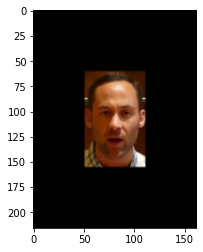

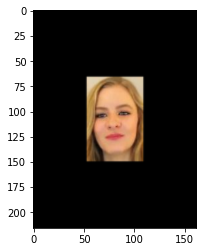

In [4]:
from matplotlib import pyplot as plt
i=0
for batch in tqdm(dm.val_dataloader()):
    image = batch['normalized'][0,:,:]
    plt.figure()
    plt.imshow(cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB))
    if i == 1:
        break
    i+=1

In [5]:
acc_class_global_1 = np.zeros(5)
acc_class_global_12 = np.zeros(5)
i=0
for batch in tqdm(dm.val_dataloader()):
    X, Y = batch['normalized'], batch['label']
    Y_pred = np.zeros_like(Y)#cnn4.predict_step(X, None)
    Y_pred_12 = np.where(Y_pred > 1/2, 1, 0)
    Y_pred_1 = np.ones_like(Y)
    acc_class_12 = np.sum(Y_pred_12 == np.array(Y), axis=0) / len(Y)
    acc_class_1 = np.sum(Y_pred_1 == np.array(Y), axis=0) / len(Y)
    acc_class_global_12 += acc_class_12
    acc_class_global_1 += acc_class_1
    i+=1
acc_class_global_12 /= i
print('1/2')
print(acc_class_global_12)
print(acc_class_global_12.mean())

acc_class_global_1 /= i
print('1')
print(acc_class_global_1)
print(acc_class_global_1.mean())

100%|██████████| 94/94 [00:04<00:00, 23.05it/s]

1/2
[0.58144947 0.29742908 0.41182772 0.43384309 0.25369385]
0.3956486406619385
1
[0.41855053 0.70257092 0.58817228 0.56615691 0.74630615]
0.6043513593380614


In [6]:
acc_class_global_1 = np.zeros(5)
acc_class_global_12 = np.zeros(5)
i=0
for batch in tqdm(dm.train_dataloader()):
    X, Y = batch['normalized'], batch['label']
    Y_pred = np.zeros_like(Y)#cnn4.predict_step(X, None)
    Y_pred_12 = np.where(Y_pred > 1/2, 1, 0)
    Y_pred_1 = np.ones_like(Y)
    acc_class_12 = np.sum(Y_pred_12 == np.array(Y), axis=0) / len(Y)
    acc_class_1 = np.sum(Y_pred_1 == np.array(Y), axis=0) / len(Y)
    acc_class_global_12 += acc_class_12
    acc_class_global_1 += acc_class_1
    i+=1
acc_class_global_12 /= i
print('1/2')
print(acc_class_global_12)
print(acc_class_global_12.mean())

acc_class_global_1 /= i
print('1')
print(acc_class_global_1)
print(acc_class_global_1.mean())

100%|██████████| 13/13 [00:00<00:00, 22.78it/s]

1/2
[0.36298077 0.31971154 0.28044872 0.40384615 0.35336538]
0.3440705128205128
1
[0.63701923 0.68028846 0.71955128 0.59615385 0.64663462]
0.6559294871794872


In [36]:
import torch
import torchmetrics
criterion = torch.nn.BCEWithLogitsLoss()
accuracy = torchmetrics.Accuracy(threshold=0.5)
y = torch.ones(10)

In [7]:
torch.randn(10)

tensor([ 0.8589, -0.3716, -0.2427,  0.0539, -1.1996,  0.7497,  0.3292, -1.5459,
        -0.1611, -0.1158])

In [43]:
print(criterion(torch.ones(10)*9, torch.ones(10)), accuracy(torch.ones(10)*9, torch.ones(10).to(torch.int64)))
print(criterion(torch.ones(10), torch.ones(10)), accuracy(torch.ones(10), torch.ones(10).to(torch.int64)))
print(criterion(torch.ones(10)/2, torch.ones(10)), accuracy(torch.ones(10)/2, torch.ones(10).to(torch.int64)))
print(criterion(torch.zeros(10), torch.ones(10)), accuracy(torch.zeros(10), torch.ones(10).to(torch.int64)))
print(criterion(torch.ones(10)*(-1), torch.ones(10)), accuracy(torch.ones(10)*(-1), torch.ones(10).to(torch.int64)))

tensor(0.0001) tensor(1.)
tensor(0.3133) tensor(1.)
tensor(0.4741) tensor(1.)
tensor(0.6931) tensor(0.)
tensor(1.3133) tensor(0.)


In [46]:
accuracy = torchmetrics.Accuracy(threshold=0.5)
print(criterion(torch.ones(10)*0.1, torch.ones(10)), accuracy(torch.ones(10)*0.1, torch.ones(10).to(torch.int64)))
print(criterion(torch.ones(10)*(-0.1), torch.ones(10)), accuracy(torch.ones(10)*(-0.1), torch.ones(10).to(torch.int64)))
print(criterion(torch.zeros(10)*0.1, torch.zeros(10)), accuracy(torch.zeros(10)*0.1, torch.zeros(10).to(torch.int64)))
print(criterion(torch.zeros(10)*(-0.1), torch.zeros(10)), accuracy(torch.zeros(10)*(-0.1), torch.zeros(10).to(torch.int64)))
accuracy = torchmetrics.Accuracy(threshold=0.0)
print()
print(criterion(torch.ones(10)*0.1, torch.ones(10)), accuracy(torch.ones(10)*0.1, torch.ones(10).to(torch.int64)))
print(criterion(torch.ones(10)*(-0.1), torch.ones(10)), accuracy(torch.ones(10)*(-0.1), torch.ones(10).to(torch.int64)))
print(criterion(torch.zeros(10)*0.1, torch.zeros(10)), accuracy(torch.zeros(10)*0.1, torch.zeros(10).to(torch.int64)))
print(criterion(torch.zeros(10)*(-0.1), torch.zeros(10)), accuracy(torch.zeros(10)*(-0.1), torch.zeros(10).to(torch.int64)))

tensor(0.6444) tensor(0.)
tensor(0.7444) tensor(0.)
tensor(0.6931) tensor(1.)
tensor(0.6931) tensor(1.)

tensor(0.6444) tensor(1.)
tensor(0.7444) tensor(0.)
tensor(0.6931) tensor(0.)
tensor(0.6931) tensor(0.)


In [42]:
print(criterion(torch.ones(10)*9, torch.zeros(10)), accuracy(torch.ones(10)*9, torch.zeros(10).to(torch.int64)))
print(criterion(torch.ones(10), torch.zeros(10)), accuracy(torch.ones(10), torch.zeros(10).to(torch.int64)))
print(criterion(torch.ones(10)/2, torch.zeros(10)), accuracy(torch.ones(10)/2, torch.zeros(10).to(torch.int64)))
print(criterion(torch.zeros(10), torch.zeros(10)), accuracy(torch.zeros(10), torch.zeros(10).to(torch.int64)))
print(criterion(torch.ones(10)*(-1), torch.zeros(10)), accuracy(torch.ones(10)*(-1), torch.zeros(10).to(torch.int64)))

tensor(9.0001) tensor(0.)
tensor(1.3133) tensor(0.)
tensor(0.9741) tensor(0.)
tensor(0.6931) tensor(1.)
tensor(0.3133) tensor(1.)


In [29]:
torch.sigmoid(torch.tensor(1))

tensor(0.7311)